In [1]:
import cupy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import optuna
import gc

from time import time
from joblib import load, dump
from matplotlib.ticker import MaxNLocator,MultipleLocator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
import sklearn.metrics as skm

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
orig_features = train.columns[1:-1].to_list()
train.shape, test.shape

((1117957, 22), (745305, 21))

## EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [4]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [5]:
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [6]:
# Checking null's
train.isna().sum().sum()

0

In [7]:
# No duplicates
train.duplicated().sum()

0

In [8]:
# Descriptive statistics
train.drop('id',axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


> Mean and Std of all columns appear very similar

In [9]:
# Lets see the data present in the independent features
for col in train.columns[1:-1]:
    uniques = ', '.join(map(str, sorted(train[col].unique())))
    print(f'Values in {col:<32}: {uniques:<69}| total={train[col].nunique()}')

Values in MonsoonIntensity                : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in TopographyDrainage              : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18     | total=19
Values in RiverManagement                 : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in Deforestation                   : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in Urbanization                    : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in ClimateChange                   : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in DamsQuality                     : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in Siltation                       : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values i

> Looks like all the columns are of **ordinal categorical type.**

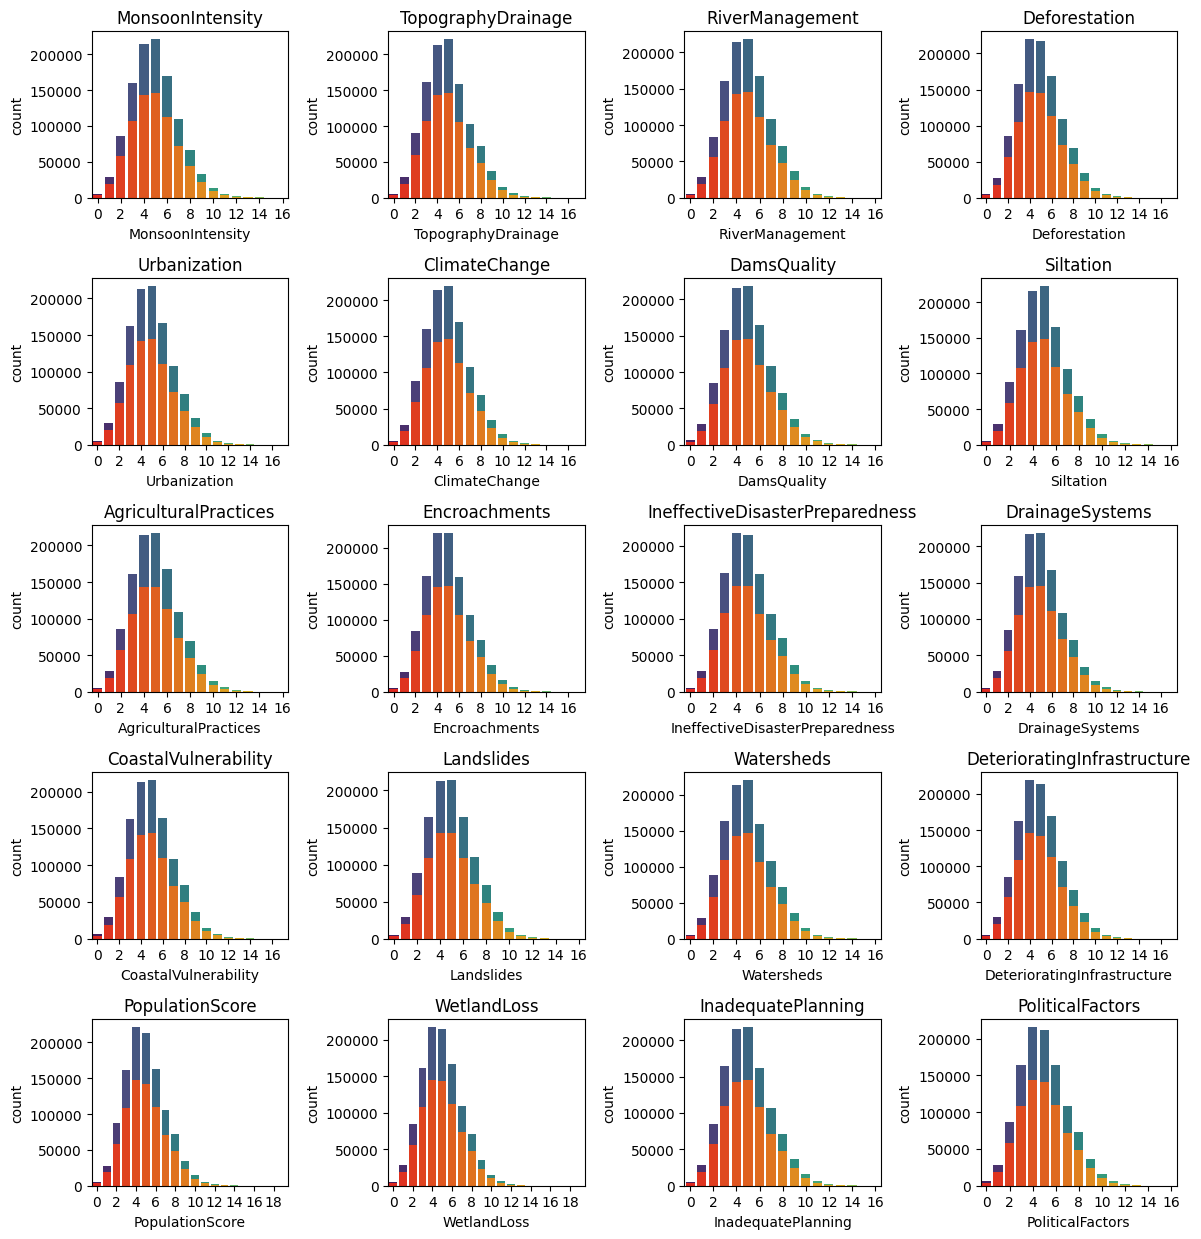

In [10]:
# Plotting the distribution of each features for Train and Test
ncol = 4
nrow = int(np.ceil(len(orig_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5))
for i,col in enumerate(orig_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sb.countplot(train,x=col,ax=ax,palette='viridis')
    sb.countplot(test,x=col,ax=ax,palette='autumn')
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

> All the features are right skewed. Also both train and test data are from the same distribution and are very similar.

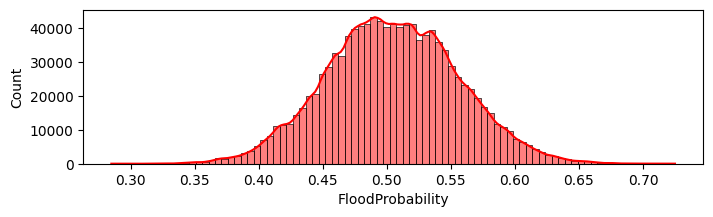

In [11]:
# Checking the target distribution
plt.figure(figsize=(8,2))
sb.histplot(train["FloodProbability"], kde=True, \
            bins=np.linspace(train["FloodProbability"].min(), train["FloodProbability"].max(), 88), color='r');
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

> It is a normal distribution with mean at 0.5

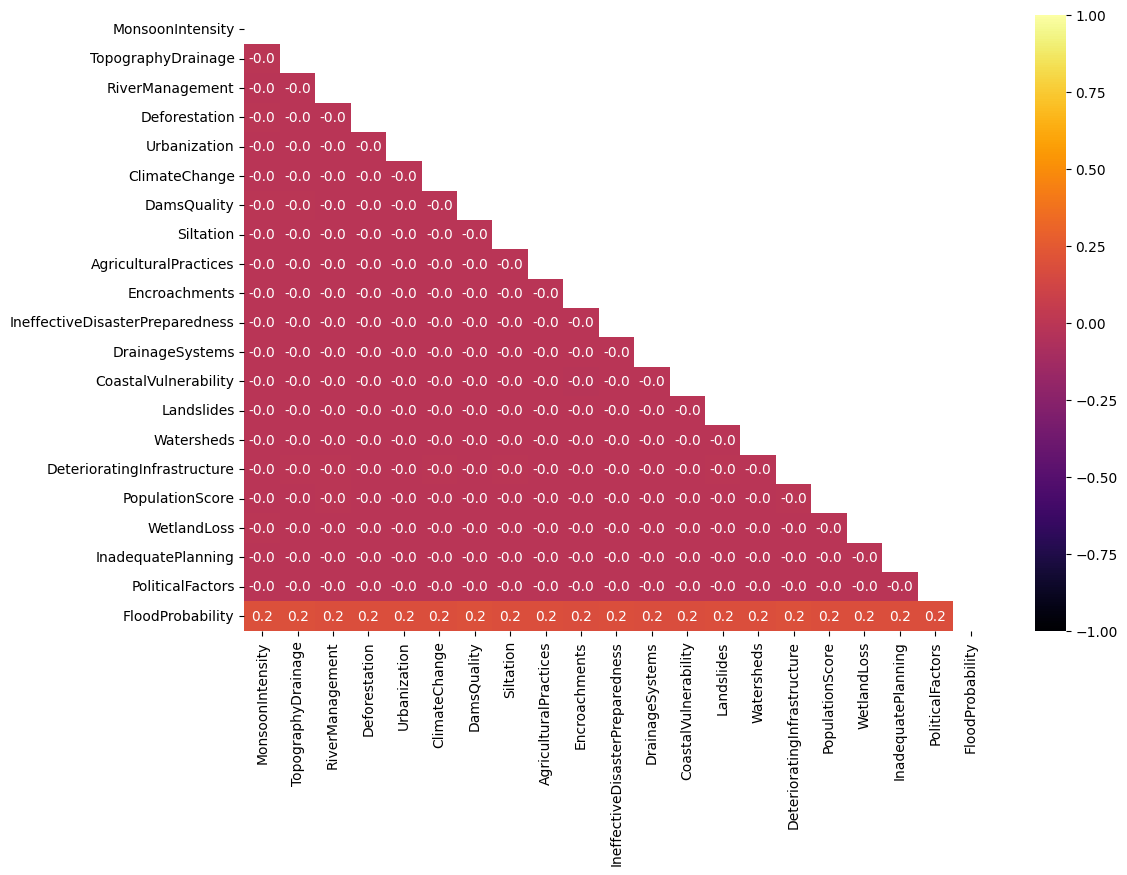

In [12]:
# cheking the correlation
plt.figure(figsize=(12,8))
corr = train.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr))
sb.heatmap(corr, vmax=1, vmin=-1, center=0, mask=mask, annot=True, fmt='0.1f', cmap='inferno');

> As it shows -0 and not 0, we can say that all the features are negatively correlated with each other. All the features are sligthly positively correlated with the Target.

In [13]:
pca = PCA()
pca.fit(train[orig_features])
pca.explained_variance_ratio_

array([0.05154727, 0.05151653, 0.05131702, 0.05107014, 0.05102997,
       0.05098338, 0.0508381 , 0.05077164, 0.05069371, 0.05056218,
       0.05051043, 0.0503371 , 0.05025168, 0.05017571, 0.05004197,
       0.04985149, 0.04968824, 0.04946495, 0.04932201, 0.04002649])

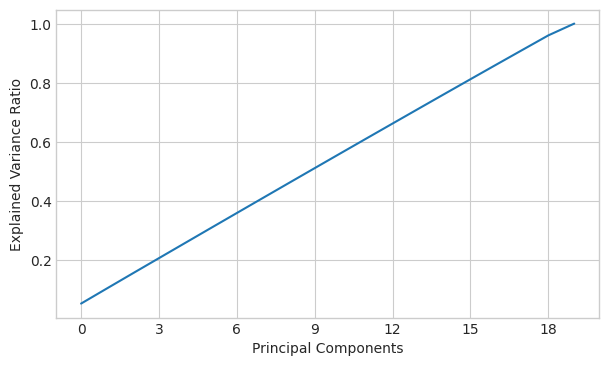

In [14]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(7,4))
sb.lineplot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

> It seems that all the features are capturing roughly the same amount of variance for PCA. Dimensionaly reduction with PCA in this case will not be of any use.

## Model Performance (Initial Data)

In [15]:
# For output text color
end = "\033[0m" ; bold = "\033[1m" ; LightRed = "\033[91m" ; LightBlue = "\033[94m"
BlueBold = LightBlue + bold ; RedBold = LightRed + bold

In [16]:
X = train.iloc[:,1:-1]
y = train['FloodProbability']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [17]:
# For checking the model performance
def cross_validate_print(alg, X, y, repeat=2, SINGLE_FOLD=False):
    
    start_time = time()
    scores = []
    oof_preds = np.full_like(y, np.nan, dtype=float)
    
    for fold,(train_idx, val_idx) in enumerate(kf.split(X, y.astype(str))):
        x_cv_tr, y_cv_tr = X.iloc[train_idx], y.iloc[train_idx]
        x_cv_vl, y_cv_vl = X.iloc[val_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_cv_vl, dtype=float)
        for i in range(repeat):
            m = clone(alg)
            if repeat > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(x_cv_tr, y_cv_tr)
            y_pred += m.predict(x_cv_vl)
        y_pred /= repeat   
        
        score = skm.r2_score(y_cv_vl, y_pred)
        print(f'# Fold {fold}: R2 Score = {score:0.5f}')
        scores.append(score)
        oof_preds[val_idx] = y_pred
        if SINGLE_FOLD: break
        
    total_time = time() - start_time
    if isinstance(m, Pipeline):
        model_name = m[-1].__class__.__name__
    else:
        model_name = m.__class__.__name__
    print(f'{BlueBold}# Mean R2 Score = {np.mean(scores):0.5f} {RedBold}± {np.std(scores):0.5f} {BlueBold}for {model_name}\n'
          f'{"Single Fold" if SINGLE_FOLD else ""}'
          f'Time Elapsed: {np.round((total_time / 60),0)} Min {end}\n')

In [18]:
# Getting the model performances
xgr_model = make_pipeline(StandardScaler(),
                          XGBRegressor(device='cuda'))

cbr_model = make_pipeline(StandardScaler(),
                          CatBoostRegressor(verbose=False, task_type='GPU'))

cross_validate_print(xgr_model, X, y)
cross_validate_print(cbr_model, X, y)

# Fold 0: R2 Score = 0.81145
# Fold 1: R2 Score = 0.81086
# Fold 2: R2 Score = 0.81084
# Fold 3: R2 Score = 0.81025
# Fold 4: R2 Score = 0.81068
# Mean R2 Score = 0.81082 ± 0.00039 for XGBRegressor
Time Elapsed: 0.0 Min 

# Fold 0: R2 Score = 0.84598
# Fold 1: R2 Score = 0.84646
# Fold 2: R2 Score = 0.84592
# Fold 3: R2 Score = 0.84637
# Fold 4: R2 Score = 0.84614
# Mean R2 Score = 0.84617 ± 0.00021 for CatBoostRegressor
Time Elapsed: 2.0 Min 



We'll try to improve the performance further by engineering new features that could be helpful for training the models.

## Feature Engineering

Lets plot the sum of all features along the column axis to the Traget

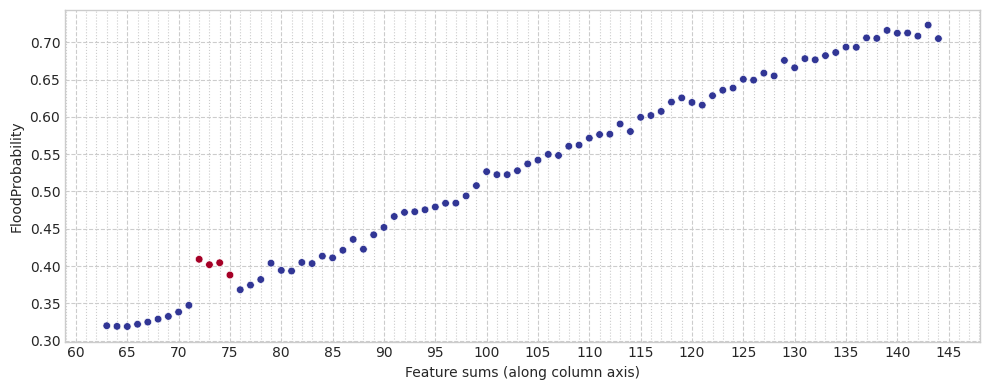

In [19]:
temp = train['FloodProbability'].groupby(X.sum(axis=1)).mean()
plt.figure(figsize=(10,4))
sb.scatterplot(x=temp.index, y=temp, c=temp.index.isin(np.arange(72,76)), s=30, cmap='RdYlBu_r')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
plt.grid(True, which='major', linestyle='--')
plt.grid(True, which='minor', linestyle=':')
plt.xlabel('Feature sums (along column axis)')
plt.tight_layout()

> We can clearly see above that feature sums 72 - 75 shows higher avg FloodProbability. Creating a boolean column indicating this difference will be helpful for linear ml models

We'll also create a sum column that contains the sum of the features along the column axis, which will be helpful for tree-based models. Additionally, we'll create several other new features that could potentially be useful for training this data.

In [20]:
# For getting the unique values in train. Used later in feature engineering
unique = []
for col in train.iloc[:,1:-1].columns:
    unique.extend(train[col].unique())
unique = list(set(unique))

In [21]:
def make_features(data, train_data=True, scaler=None):
    '''
    For feature engineering of both train and test data. Returns the data with new features added in standardized form.
    The standardization parameters are learned only from the train data so as to avoid data leakage.
    '''
    df = data.copy()
    with tqdm(total=12 ,desc='processing...') as pbar:
        sort_cols = [f'col{i+1}' for i in range(len(orig_features))]
        
        df['sum'] = df.sum(axis=1)         
        pbar.update(1)
        
        df['linear_ft'] = df['sum'].isin(np.arange(72, 76)).astype(int)
        pbar.update(1)
        
        df['median'] = df[orig_features].median(axis=1)         
        pbar.update(1)
        
        df['std'] = df[orig_features].std(axis=1)         
        pbar.update(1)
        
        df[sort_cols] = np.sort(df[orig_features].values, axis=1)         
        pbar.update(1)
        
        for u in unique:
            df[f'count_{u}'] = (df[orig_features] == u).sum(axis=1)
        pbar.update(1)
        
        df['mean'] = df[orig_features].mean(axis=1)
        pbar.update(1)
        
        df['max'] = df[orig_features].max(axis=1) 
        pbar.update(1)               
        
        df['min'] = df[orig_features].min(axis=1)
        pbar.update(1)
        
        df['skew'] = df[orig_features].skew(axis=1)
        pbar.update(1)
        
        df['kurt'] = df[orig_features].kurt(axis=1)
        pbar.update(1)
        
        if train_data:
            scaler = StandardScaler()
            scaler.fit(df)
            df[df.columns.to_list()] = scaler.transform(df.values)
            pbar.update(1)
        else:
            df[df.columns.to_list()] = scaler.transform(df.values)
            pbar.update(1)
        
    return df, scaler

In [22]:
train_df, scaler = make_features(X)
dump(train_df,'train_df.joblib')
train_df.head()

processing...: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,count_15,count_16,count_17,count_18,count_19,mean,max,min,skew,kurt
0,0.038198,1.467769,0.021561,1.490363,0.507578,-0.453941,-0.458881,-0.933107,-0.939124,-0.455632,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-0.576389,-0.967722,0.473994,0.351678,-0.552520
1,0.524488,0.990186,-0.461022,-0.459251,1.467552,1.489938,-0.938943,0.034951,-0.455692,0.504372,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-0.576389,-0.201344,-1.920120,-0.518854,-0.416219
2,0.524488,0.035021,0.504143,1.002959,-0.932383,1.003968,-1.899068,0.034951,-0.455692,0.024370,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,0.025493,-0.967722,-0.723063,-1.648163,-0.736429
3,-0.934382,-0.442562,0.504143,0.028152,-0.452396,1.489938,-0.458881,1.003010,0.511171,1.464377,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,0.627374,-0.967722,0.473994,-0.575221,-0.609961
4,0.038198,-0.920145,-1.426186,0.515556,-0.452396,-0.453941,-0.938943,-0.933107,-0.939124,-0.935635,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-3.224667,-2.500477,-0.723063,-0.305973,-0.886395


In [23]:
test_df, _ = make_features(test.iloc[:,1:], train_data=False, scaler=scaler)
dump(test_df,'test_df.joblib')
test_df.head()

processing...: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,count_15,count_16,count_17,count_18,count_19,mean,max,min,skew,kurt
0,-0.448092,0.512604,-0.943604,0.028152,0.507578,1.003968,1.461369,1.003010,1.478035,-0.455632,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,1.470008,-0.967722,1.671050,-0.679136,-0.985432
1,-0.448092,-0.442562,-1.426186,1.977766,0.027591,0.032029,-0.458881,1.003010,0.027740,-0.455632,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-1.057894,-0.201344,-0.723063,0.209093,0.408414
2,-1.906963,-0.920145,0.504143,0.028152,0.987565,-1.425881,-0.458881,0.518981,-0.455692,-1.415637,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-1.057894,-0.201344,-0.723063,-0.202562,-0.814604
3,-1.420672,-0.442562,-0.461022,0.515556,-0.452396,0.032029,-0.458881,-0.933107,-0.455692,-0.455632,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-0.817142,-0.967722,0.473994,0.155842,-0.230696
4,0.524488,-0.920145,-1.426186,-0.459251,0.507578,-0.453941,0.021182,0.034951,-0.939124,0.984374,...,-0.044877,-0.025772,-0.008025,-0.002502,-0.000946,-0.817142,-0.967722,0.473994,-0.363181,-0.384101


**Lets check the model performances again now after adding the new features**

In [24]:
X = train_df
y = train['FloodProbability']

cross_validate_print(xgr_model, X, y)
cross_validate_print(cbr_model, X, y)

# Fold 0: R2 Score = 0.86869
# Fold 1: R2 Score = 0.86886
# Fold 2: R2 Score = 0.86883
# Fold 3: R2 Score = 0.86867
# Fold 4: R2 Score = 0.86871
# Mean R2 Score = 0.86875 ± 0.00008 for XGBRegressor
Time Elapsed: 1.0 Min 

# Fold 0: R2 Score = 0.86886
# Fold 1: R2 Score = 0.86906
# Fold 2: R2 Score = 0.86893
# Fold 3: R2 Score = 0.86887
# Fold 4: R2 Score = 0.86882
# Mean R2 Score = 0.86891 ± 0.00009 for CatBoostRegressor
Time Elapsed: 2.0 Min 



> As we can see from above, after feature engineering, the performance of the models have significantly increased.

## Model Training and Hyperparameter Tuning

In [26]:
def cross_validate_tuner(model, X, y, XGB=False):
    
    r2_scores = []
    for trn_idx,val_idx in kf.split(X, y.astype(int)):
        x_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if XGB: x_trn, x_val = cp.array(x_trn), cp.array(x_val)
        
        model.fit(x_trn, y_trn)
        y_prd = model.predict(x_val)
        fold_r2 = skm.r2_score(y_val, y_prd)
        r2_scores.append(fold_r2)
        
    return np.mean(r2_scores)

### XGBoost Model

In [45]:
fixed_params_xgr = {
    'device'      : 'cuda',
    'n_estimators': 500,
    'tree_method' : 'hist',
    'objective'   : 'reg:squarederror',
    'n_jobs'      : -1
}

In [27]:
def objective(trial):
    params = {
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 1, 12),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_float('min_child_weight', 1, 20)
    }
    
    gc.collect()
    xgr = XGBRegressor(**params, **fixed_params_xgr)
    r2_score = cross_validate_tuner(xgr, X, y, XGB=True)
    
    return r2_score

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_r2_xgr = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Optimizing R2 for XGBRegressor')

[I 2024-06-21 15:33:58,341] A new study created in memory with name: Optimizing R2 for XGBRegressor


In [29]:
optimize_r2_xgr.optimize(objective, timeout=3*60*60, show_progress_bar=True)
dump(optimize_r2_xgr,'Optimizing R2 for XGBRegressor.pkl')

   0%|          | 00:00/3:00:00

[I 2024-06-21 15:35:14,710] Trial 1 finished with value: 0.8692619296112062 and parameters: {'learning_rate': 0.017152477706078702, 'max_depth': 9, 'colsample_bytree': 0.8582643430453151, 'subsample': 0.46291001117728725, 'min_child_weight': 1.1997230822059268}. Best is trial 1 with value: 0.8692619296112062.
[I 2024-06-21 15:35:44,229] Trial 2 finished with value: 0.8654751694426064 and parameters: {'learning_rate': 0.01817635256034164, 'max_depth': 4, 'colsample_bytree': 0.23938378101038688, 'subsample': 0.2785779179452582, 'min_child_weight': 1.7708313437501355}. Best is trial 1 with value: 0.8692619296112062.
[I 2024-06-21 15:36:26,539] Trial 3 finished with value: 0.8445737845706589 and parameters: {'learning_rate': 0.0036118209839393375, 'max_depth': 7, 'colsample_bytree': 0.8641555603376752, 'subsample': 0.12087870534756442, 'min_child_weight': 12.244937113385998}. Best is trial 1 with value: 0.8692619296112062.
[I 2024-06-21 15:36:49,063] Trial 4 finished with value: 0.78761390

['Optimizing R2 for XGBRegressor.pkl']

### CatBoost Model

In [46]:
fixed_params_ctr = {
    'verbose'       : False,
    'task_type'     : 'GPU',
    'thread_count'  : -1,
    'iterations'    : 500,
    'max_bin'       : 2540,
    'bootstrap_type': 'Bernoulli'
}

In [32]:
def objective(trial):
    params = {
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth':             trial.suggest_int('depth', 1, 10),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_data_in_leaf':  trial.suggest_float('min_data_in_leaf', 1, 100)
    }
    
    gc.collect()
    cbr = CatBoostRegressor(**params, **fixed_params_ctr)
    r2_score = cross_validate_tuner(cbr, X, y)
    
    return r2_score

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_r2_cbr = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Optimizing R2 for CatBoostRegressor')

[I 2024-06-21 22:21:40,227] A new study created in memory with name: Optimizing R2 for CatBoostRegressor


In [33]:
optimize_r2_cbr.optimize(objective, timeout=3*60*60, show_progress_bar=True)
dump(optimize_r2_cbr,'Optimizing R2 for CatBoostRegressor.pkl')

   0%|          | 00:00/3:00:00

[I 2024-06-21 22:22:04,966] Trial 0 finished with value: 0.8547257419729183 and parameters: {'learning_rate': 0.005011066719315042, 'depth': 5, 'subsample': 0.6220291300711052, 'min_data_in_leaf': 14.225935972786427}. Best is trial 0 with value: 0.8547257419729183.
[I 2024-06-21 22:22:36,362] Trial 1 finished with value: 0.8685605000027368 and parameters: {'learning_rate': 0.04001378057639851, 'depth': 8, 'subsample': 0.5364606555784855, 'min_data_in_leaf': 74.98104468629488}. Best is trial 1 with value: 0.8685605000027368.
[I 2024-06-21 22:23:06,229] Trial 2 finished with value: 0.8684112240770208 and parameters: {'learning_rate': 0.08412246727495014, 'depth': 9, 'subsample': 0.1699082561593529, 'min_data_in_leaf': 97.39934943571599}. Best is trial 1 with value: 0.8685605000027368.
[I 2024-06-21 22:23:38,266] Trial 3 finished with value: 0.8615118112218217 and parameters: {'learning_rate': 0.005602770227127552, 'depth': 9, 'subsample': 0.3092994656443176, 'min_data_in_leaf': 31.423738

['Optimizing R2 for CatBoostRegressor.pkl']

### LightGBM Model

In [47]:
fixed_params_lbr = {
    'verbosity'   : -1,
    'device'      : 'gpu',
    'n_jobs'      : -1,
    'n_estimators': 500,
    'objective'   : 'regression',
    'metric'      : 'rmse',
    'bagging_freq': 1
}

In [41]:
def objective(trial):
    params = {
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves':       trial.suggest_int('num_leaves', 2, 2**8),
        'subsample':        trial.suggest_float('subsample', 0.05, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }
    
    gc.collect()
    lbr = LGBMRegressor(**params, **fixed_params_lbr)
    r2_score = cross_validate_tuner(lbr, X, y)
    
    return r2_score

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_r2_lbr = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Optimizing R2 for LGBMRegressor')

[I 2024-06-22 06:23:42,572] A new study created in memory with name: Optimizing R2 for LGBMRegressor


In [43]:
optimize_r2_lbr.optimize(objective, timeout=3*60*60, show_progress_bar=True)
dump(optimize_r2_lbr,'Optimizing R2 for LGBMRegressor.pkl')

   0%|          | 00:00/3:00:00

[I 2024-06-22 06:25:06,083] Trial 1 finished with value: 0.867677066508862 and parameters: {'learning_rate': 0.028085937263884694, 'num_leaves': 7, 'subsample': 0.6551096953254762, 'colsample_bytree': 0.8932185671540099, 'min_data_in_leaf': 88}. Best is trial 1 with value: 0.867677066508862.
[I 2024-06-22 06:31:16,911] Trial 2 finished with value: 0.8616277051460003 and parameters: {'learning_rate': 0.004874107941466133, 'num_leaves': 158, 'subsample': 0.466220086403507, 'colsample_bytree': 0.6399761447656416, 'min_data_in_leaf': 84}. Best is trial 1 with value: 0.867677066508862.
[I 2024-06-22 06:35:51,651] Trial 3 finished with value: 0.8686341000861952 and parameters: {'learning_rate': 0.042642043753047844, 'num_leaves': 43, 'subsample': 0.44152805115574323, 'colsample_bytree': 0.3865456332719599, 'min_data_in_leaf': 63}. Best is trial 3 with value: 0.8686341000861952.
[I 2024-06-22 06:41:52,106] Trial 4 finished with value: 0.8669216652312663 and parameters: {'learning_rate': 0.084

['Optimizing R2 for LGBMRegressor.pkl']

### XGBoost Random Forest Model

In [27]:
fixed_params_xgrf = {
    'device'       : 'cuda',
    'booster'      : 'gbtree',
    'learning_rate': 1,
    'tree_method'  : 'hist',
    'n_estimators' : 1,
    'objective'    : 'reg:squarederror',
    'n_jobs'       : -1,
}

In [28]:
def objective(trial):
    params = {
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 50, 1000),
        'max_depth':         trial.suggest_int('max_depth', 1, 30),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 250),
        'lambda':            trial.suggest_float('lambda', 1, 10)
    }
    
    gc.collect()
    xgrf = XGBRegressor(**params, **fixed_params_xgrf)
    r2_score = cross_validate_tuner(xgrf, X, y, XGB=True)
    
    return r2_score

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_r2_xgrf = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Optimizing R2 for XGRF')
    

[I 2024-06-22 10:54:24,205] A new study created in memory with name: Optimizing R2 for XGRF


In [29]:
optimize_r2_xgrf.optimize(objective, timeout=3*60*60, show_progress_bar=True)
dump(optimize_r2_xgrf,'Optimizing R2 for XGRF.pkl')

   0%|          | 00:00/3:00:00

[I 2024-06-22 10:56:07,061] Trial 0 finished with value: 0.867998578160918 and parameters: {'num_parallel_tree': 563, 'max_depth': 17, 'colsample_bynode': 0.7092800218044961, 'subsample': 0.5137817830813406, 'min_child_weight': 162, 'lambda': 9.738520448978319}. Best is trial 0 with value: 0.867998578160918.
[I 2024-06-22 11:01:36,475] Trial 1 finished with value: 0.8685031320570491 and parameters: {'num_parallel_tree': 871, 'max_depth': 16, 'colsample_bynode': 0.9010272329578238, 'subsample': 0.2365750392872114, 'min_child_weight': 55, 'lambda': 2.4481408144117096}. Best is trial 1 with value: 0.8685031320570491.
[I 2024-06-22 11:02:04,785] Trial 2 finished with value: 0.8667786992253321 and parameters: {'num_parallel_tree': 334, 'max_depth': 7, 'colsample_bynode': 0.4776939767247429, 'subsample': 0.5347816244641138, 'min_child_weight': 243, 'lambda': 3.5813199946906145}. Best is trial 1 with value: 0.8685031320570491.
[I 2024-06-22 11:02:25,765] Trial 3 finished with value: 0.7956676

['Optimizing R2 for XGRF.pkl']

### Ridge Regression Model

In [33]:
def objective(trial):
    
    params = {
        'alpha':    trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    }
    
    ridge = Ridge(**params)
    r2_score = cross_validate_tuner(ridge, X, y)
    
    return r2_score

TPESampler = optuna.samplers.TPESampler()
optimize_r2_ridge = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Optimizing R2 for Ridge')

[I 2024-06-22 14:19:36,388] A new study created in memory with name: Optimizing R2 for Ridge


In [34]:
optimize_r2_ridge.optimize(objective, n_trials=50, show_progress_bar=True)
dump(optimize_r2_ridge,'Optimizing R2 for Ridge.pkl')

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-22 14:19:44,758] Trial 0 finished with value: 0.8524225470820136 and parameters: {'alpha': 0.029554420799854073}. Best is trial 0 with value: 0.8524225470820136.
[I 2024-06-22 14:19:50,257] Trial 1 finished with value: 0.8524225470671312 and parameters: {'alpha': 2.8551384941763705e-05}. Best is trial 0 with value: 0.8524225470820136.
[I 2024-06-22 14:19:55,675] Trial 2 finished with value: 0.8524225470794706 and parameters: {'alpha': 0.010657750829229788}. Best is trial 0 with value: 0.8524225470820136.
[I 2024-06-22 14:20:00,883] Trial 3 finished with value: 0.8524225470785307 and parameters: {'alpha': 0.004008857709217448}. Best is trial 0 with value: 0.8524225470820136.
[I 2024-06-22 14:20:06,344] Trial 4 finished with value: 0.8524225483477794 and parameters: {'alpha': 38.43380149689896}. Best is trial 4 with value: 0.8524225483477794.
[I 2024-06-22 14:20:11,586] Trial 5 finished with value: 0.8524225470651693 and parameters: {'alpha': 2.547275747378794e-05}. Best is tr

['Optimizing R2 for Ridge.pkl']

## Ensemble Prediction

In [42]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=77)
FOLDS = 7

def cross_validate_predict(model, X, y, test_data, repeat=2):
    '''
    Function to make the train preds and test preds using cross validation.
    The resultant ensemble of preds will be further used to make the final test prediction.
    '''
    start_time = time()
    scores = []
    oof_preds_full = np.full_like(y, np.nan, dtype=float)
    test_pred_final = np.zeros(len(test_data), dtype=float)
    
    for fold,(train_idx, val_idx) in enumerate(kf.split(X, y.astype(str))):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        y_val_pred = np.zeros_like(y_val, dtype=float)
        y_pred = np.zeros(len(test_data), dtype=float)
        
        for i in range(repeat):
            m = clone(model)
            if repeat > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_val_pred += m.predict(x_val)
            y_pred += m.predict(test_data)
        y_val_pred /= repeat
        y_pred /= repeat
        
        score = skm.r2_score(y_val, y_val_pred)
        print(f'# Fold {fold}: R2 Score = {score:0.5f}')
        scores.append(score)
        oof_preds_full[val_idx] = y_val_pred
        test_pred_final += y_pred
        
    test_pred_final /= FOLDS
    
    total_time = time() - start_time
    if isinstance(m, Pipeline):
        model_name = m[-1].__class__.__name__
    else:
        model_name = m.__class__.__name__
        
    print(f'{BlueBold}# Mean R2 Score = {np.mean(scores):0.5f} {RedBold}± {np.std(scores):0.5f} {BlueBold}for {model_name}\n'
          f'Time Elapsed: {np.round((total_time / 60),0)} Min {end}\n')

    return oof_preds_full, test_pred_final

### Getting The Predictions

In [49]:
# Getting the best parameters obtained from Hyperparameter Tuning
xgr_params = optimize_r2_xgr.best_trial.params
cbr_params = optimize_r2_cbr.best_trial.params
lbr_params = optimize_r2_lbr.best_trial.params
xgrf_params = optimize_r2_xgrf.best_trial.params
ridge_params = optimize_r2_ridge.best_trial.params

In [51]:
xgr_tr_pred1, xgr_ts_pred1 = cross_validate_predict(XGBRegressor(**fixed_params_xgr, **xgr_params),
                                                    X, y, test_df)

cbr_tr_pred2, cbr_ts_pred2 = cross_validate_predict(CatBoostRegressor(**fixed_params_ctr, **cbr_params),
                                                    X, y, test_df)

lgr_tr_pred3, lgr_ts_pred3 = cross_validate_predict(LGBMRegressor(**fixed_params_lbr, **lbr_params),
                                                    X, y, test_df)

xgrf_tr_pred4, xgrf_ts_pred4 = cross_validate_predict(XGBRegressor(**fixed_params_xgrf, **xgrf_params),
                                                      X, y, test_df)

ridge_tr_pred5, ridge_ts_pred5 = cross_validate_predict(Ridge(**ridge_params), X, y, test_df)

# Fold 0: R2 Score = 0.86984
# Fold 1: R2 Score = 0.86998
# Fold 2: R2 Score = 0.86962
# Fold 3: R2 Score = 0.86931
# Fold 4: R2 Score = 0.86865
# Fold 5: R2 Score = 0.86989
# Fold 6: R2 Score = 0.86849
# Mean R2 Score = 0.86940 ± 0.00056 for XGBRegressor
Time Elapsed: 4.0 Min 

# Fold 0: R2 Score = 0.86952
# Fold 1: R2 Score = 0.86965
# Fold 2: R2 Score = 0.86941
# Fold 3: R2 Score = 0.86895
# Fold 4: R2 Score = 0.86835
# Fold 5: R2 Score = 0.86961
# Fold 6: R2 Score = 0.86815
# Mean R2 Score = 0.86909 ± 0.00058 for CatBoostRegressor
Time Elapsed: 3.0 Min 

# Fold 0: R2 Score = 0.86988
# Fold 1: R2 Score = 0.86997
# Fold 2: R2 Score = 0.86962
# Fold 3: R2 Score = 0.86926
# Fold 4: R2 Score = 0.86869
# Fold 5: R2 Score = 0.86991
# Fold 6: R2 Score = 0.86841
# Mean R2 Score = 0.86939 ± 0.00058 for LGBMRegressor
Time Elapsed: 13.0 Min 

# Fold 0: R2 Score = 0.86955
# Fold 1: R2 Score = 0.86970
# Fold 2: R2 Score = 0.86934
# Fold 3: R2 Score = 0.86901
# Fold 4: R2 Score = 0.86838
# Fold 5

In [52]:
# Creating the predictions dataset for final prediction
ensemble_train = np.c_[xgr_tr_pred1, cbr_tr_pred2, lgr_tr_pred3, xgrf_tr_pred4, ridge_tr_pred5]
ensemble_test = np.c_[xgr_ts_pred1, cbr_ts_pred2, lgr_ts_pred3, xgrf_ts_pred4, ridge_ts_pred5]

np.save('ensemble_train.npy', ensemble_train)
np.save('ensemble_test.npy', ensemble_test)

In [53]:
ensemble_train[:5,:]

array([[0.47669496, 0.47669647, 0.47780584, 0.47718488, 0.47711605],
       [0.47427475, 0.47489054, 0.47373573, 0.47392415, 0.47564773],
       [0.50841367, 0.50711799, 0.50823631, 0.50893119, 0.50616242],
       [0.53784844, 0.53692182, 0.53760138, 0.53800228, 0.53451644],
       [0.41057269, 0.41146877, 0.41049657, 0.40883538, 0.39420575]])

In [54]:
ensemble_test[:5,:]

array([[0.57765392, 0.57761949, 0.57759627, 0.57726853, 0.57419706],
       [0.45609147, 0.45632285, 0.45612715, 0.45562509, 0.45349977],
       [0.44966013, 0.44838447, 0.44995146, 0.44861799, 0.45330698],
       [0.46738401, 0.4671034 , 0.46646066, 0.46641315, 0.46343886],
       [0.46724054, 0.46793924, 0.46703459, 0.46518403, 0.46457902]])

### Optimizing The Weights For Final Predictions

In [55]:
def objective(trial):
    
    weights = [trial.suggest_float(f'w{i}', 0, 1) for i in range(1,6)]   # weight suggestions
    weights = np.array(weights) / np.sum(weights)                        # normalizing
    
    ensemble_pred = ensemble_train.dot(weights)
    r2_score = skm.r2_score(y, ensemble_pred)
    return r2_score

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_weights = optuna.create_study(direction='maximize', sampler=TPESampler, study_name='Ensemble Weights')

[I 2024-06-22 15:15:11,803] A new study created in memory with name: Ensemble Weights


In [56]:
optimize_weights.optimize(objective, n_trials=1000, show_progress_bar=True)
dump(optimize_weights,'Ensemble Weights.pkl')

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-06-22 15:15:15,805] Trial 0 finished with value: 0.8656891787408675 and parameters: {'w1': 0.4035645826923071, 'w2': 0.2039812668039973, 'w3': 0.071495567563443, 'w4': 0.09085941664022279, 'w5': 0.6438874167878319}. Best is trial 0 with value: 0.8656891787408675.
[I 2024-06-22 15:15:15,831] Trial 1 finished with value: 0.8682294893978401 and parameters: {'w1': 0.6835220712076572, 'w2': 0.896564548681004, 'w3': 0.06967178702859245, 'w4': 0.9471727309111587, 'w5': 0.8180234578653282}. Best is trial 1 with value: 0.8682294893978401.
[I 2024-06-22 15:15:15,869] Trial 2 finished with value: 0.8683332076948796 and parameters: {'w1': 0.6881688512406835, 'w2': 0.7861433956613773, 'w3': 0.006182411911127339, 'w4': 0.8738006995827925, 'w5': 0.693439202968007}. Best is trial 2 with value: 0.8683332076948796.
[I 2024-06-22 15:15:15,909] Trial 3 finished with value: 0.8684610424064003 and parameters: {'w1': 0.6395676961974356, 'w2': 0.2204832584786901, 'w3': 0.3250166155885583, 'w4': 0.5453

['Ensemble Weights.pkl']

**After optimizing the weights, the best R2 Score obtained is 0.8694**

In [70]:
weights = optimize_weights.best_trial.params
weights

{'w1': 0.8606246181267914,
 'w2': 0.10463267018423746,
 'w3': 0.9037445274888014,
 'w4': 0.0021541937324386085,
 'w5': 0.0003213731643340941}

In [71]:
# Normalizing the weights
weights = np.array(list(weights.values()))
weights /= np.sum(weights)
weights

array([4.59863756e-01, 5.59091289e-02, 4.82904328e-01, 1.15106587e-03,
       1.71721639e-04])

### Making The Final Test Predictions

In [76]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['FloodProbability'] = ensemble_test.dot(weights)
submission.to_csv('submission.csv',index=False)

In [78]:
submission

,id,FloodProbability
0,1117957,0.577623
1,1117958,0.456121
2,1117959,0.449729
3,1117960,0.466921
4,1117961,0.467177
...,...,...
745300,1863257,0.475448
745301,1863258,0.442500
745302,1863259,0.620384
745303,1863260,0.549054
